# Github Repository:
https://github.com/syedrazaali/DL4H_Team_148


# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction
### Background of the problem
Patients in Intensive Care Units (ICUs) present complex and critical health profiles that are monitored through Electronic Health Records (EHRs). These records include both numerical time series and text-based clinical notes, often sampled at irregular intervals, which presents unique challenges for effective prediction and management of patient outcomes. Accurate and timely predictions can significantly impact the quality of care, informing crucial clinical decisions such as interventions or evaluations.

### Importance of the Problem:
Addressing the irregularities in multimodal data (time series and text) is crucial because it directly affects the predictive accuracy and reliability of the models used in medical settings. Better predictive models can lead to improved patient outcomes and more efficient use of medical resources.

### Difficulty of the Problem:

The primary challenge lies in effectively integrating these multimodal data sources, which are inherently asynchronous and irregularly sampled, into a coherent framework that improves prediction accuracy. Traditional methods often treat these data sources independently or fail to account for the temporal irregularities inherent in the data collection process.

### State of the Art:

Recent advances have explored deep learning approaches to better handle multimodal EHR data. Techniques like LSTM (Long Short-Term Memory) networks have been adapted to deal with time-series data, and various forms of attention mechanisms have been used to manage the irregular sampling of clinical notes. However, these methods often treat modalities separately or do not fully capitalize on the interactions between them.

### Paper Explanantion:
The paper "Improving Medical Predictions by Irregular Multimodal Electronic Health Records Modeling" proposes a novel approach that addresses these challenges by dynamically integrating hand-crafted imputation embeddings with learned interpolation embeddings through a gating mechanism for time series data, and by casting clinical notes as multivariate time series handled with a time attention mechanism. This method not only considers the irregularities in each modality but also integrates them, potentially offering a more robust predictive model.

### Innovations of the Method
The paper introduces a unique interleaved attention mechanism that integrates irregularities across modalities at multiple temporal steps, a significant innovation that allows for a deeper understanding and utilization of the temporal dynamics in multimodal data.

### Effectiveness of the Proposed Method
The method demonstrated superior performance over state-of-the-art baselines in two medical prediction tasks, showing improvements in F1 scores for time series, clinical notes, and multimodal fusion scenarios, thus highlighting the benefit of its approach to managing irregularities in multimodal EHR data.

### Contribution to the Research Regime

This work advances the field of medical informatics by demonstrating how to effectively integrate multimodal EHR data, which includes both structured and unstructured data types, into a unified predictive model. It sets a new standard for future research in the area and could influence practical applications in clinical settings.



# Scope of Reproducibility:




The goal of this project is to replicate and verify key findings from the referenced paper, which discusses advanced techniques for managing irregularities in multimodal data within intensive care units (ICUs) using electronic health records (EHRs). The paper emphasizes the integration of numerical time series data with unstructured clinical notes to improve prediction accuracy in medical settings.

# Hypotheses from the Paper and Corresponding Experiments
### Hypothesis 1:
**Handling of Irregular Time Series Data Enhances Model Performance**

The paper suggests that dynamically incorporating hand-crafted imputation embeddings into learned interpolation embeddings via a gating mechanism can significantly improve the handling of missing and irregularly sampled data, thereby enhancing model performance.

**Experiment:**
While the exact replication of the gating mechanism was beyond the scope of the available tools and time, we implemented basic data imputation techniques for numerical time series data and integrated these with clinical note embeddings to observe any potential improvement in prediction outcomes.

### Hypothesis 2:
**Incorporation of Textual Data Through Advanced NLP Techniques Improves Predictive Accuracy**

The original study posits that utilizing a time attention mechanism to manage irregularities in clinical note sequences can improve the modeling of patient conditions over time.

**Experiment:**\
We processed clinical notes using natural language processing (NLP) techniques, converting them into vector representations using pre-trained Word2Vec embeddings. These were then combined with structured numerical ICU data to train an LSTM model, aiming to capture both temporal and contextual information from the patient records.


You can also use code to display images, see the code below.

The images must be saved in Google Drive first.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [2]:
# import  packages you need
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from google.colab import drive


##  Data

  ---
This project uses the MIMIC III dataset, a freely accessible database comprising de-identified health-related data associated with over forty thousand patients who stayed in intensive care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The dataset includes detailed data such as vital signs, medications, laboratory measurements, observations, and notes taken during the care of the patients.

### Source of the Data
The data was sourced from the MIMIC-III (Medical Information Mart for Intensive Care) clinical database. For this project, specific tables such as CHARTEVENTS, LABEVENTS, NOTEEVENTS, ADMISSIONS, PATIENTS, and ICUSTAYS were used. The raw data was first loaded into a PostgreSQL database using SQL scripts to manage and query the data effectively.

### Data Preprocessing
**SQL Preprocessing:**
SQL queries were extensively used to preprocess the data. This involved:

Importing CSV data into PostgreSQL tables.
* Creating structured queries to filter and aggregate necessary features from different tables based on specific medical IDs and timestamps.
* Example SQL query used for creating an aggregated table:

```
CREATE TABLE merged_data AS
SELECT
    a.SUBJECT_ID, a.HADM_ID, a.ADMITTIME, a.DISCHTIME, a.DEATHTIME, p.GENDER,
    EXTRACT(YEAR FROM age(a.ADMITTIME, p.DOB)) AS age_at_admission,
    a.DIAGNOSIS, i.ICUSTAY_ID, i.INTIME AS icu_intime, i.OUTTIME AS icu_outtime,
    i.LOS AS icu_los,
    (CASE WHEN a.DEATHTIME IS NOT NULL THEN 1 ELSE 0 END) AS mortality_label,
    STRING_AGG(ne.text, ' ') AS all_notes
FROM admissions a
JOIN patients p ON a.SUBJECT_ID = p.SUBJECT_ID
LEFT JOIN icustays i ON a.SUBJECT_ID = i.SUBJECT_ID AND a.HADM_ID = i.HADM_ID
LEFT JOIN noteevents ne ON a.SUBJECT_ID = ne.SUBJECT_ID AND a.HADM_ID = ne.HADM_ID
GROUP BY a.SUBJECT_ID, a.HADM_ID, a.ADMITTIME, a.DISCHTIME, a.DEATHTIME, p.GENDER, p.DOB,
    a.DIAGNOSIS, i.ICUSTAY_ID, i.INTIME, i.OUTTIME, i.LOS;

```

(full details on the sql queries will be accessible on the github repository for this project in the final submission)
### Feature Engineering in Python:

* The aggregated data was then exported as a CSV file and loaded into a Python environment for further manipulation using Pandas.
* Clinical notes were preprocessed using NLP techniques, including lowercasing, tokenization, and lemmatization to prepare for Word2Vec embedding.
* Numerical and textual data were combined to form a unified feature set for model training.

### Statistics
Basic descriptive statistics of the dataset such as size, mean, standard deviation, and the distribution of key variables were computed to understand the dataset's characteristics. This also included checking for missing data and applying appropriate imputation methods where necessary.

### Illustration
The analysis of the MIMIC-III dataset included a series of visualizations to better understand the distributions and relationships within the data. Here is a detailed overview of each type of visualization employed:

**Distribution Checks**
1. Histograms: These were used to analyze the distribution of **hospital_stay_length**, **icu_stay_length**, and **age_at_admission**.
* Hospital Stay Length: Displayed as a histogram to show the frequency distribution of the length of hospital stays among patients.
* ICU Stay Length: Illustrated through a histogram to depict how long patients typically stay in the ICU.
* Age at Admission: This histogram shows the age distribution of patients at the time of admission, helping identify the age groups most commonly admitted to the ICU.

**Box Plots**\
Box plots were employed to provide a graphical representation of the central tendency and variability of the aforementioned metrics.

* Hospital Stay Length: The box plot highlights the median, quartiles, and potential outliers in the length of hospital stays.
* ICU Stay Length: Similar to hospital stay length, this plot provides insights into the distribution of ICU stay lengths, including outliers.
* Age at Admission: Shows the spread of ages at admission, highlighting the interquartile range and any potential outliers in age distribution.

**Bar Chart**
* Gender Distribution: A bar chart was used to visualize the frequency of different genders within the dataset, which helps in understanding the demographic breakdown of the patient population.

**Correlation Analysis**
* Correlation Heatmap: A heatmap was created to visualize the correlation coefficients between key variables such as hospital_stay_length, icu_stay_length, age_at_admission, and mortality_label. This helps to identify potential relationships and dependencies between different health outcomes and patient demographics.

**Text Analysis**
* Text Length Distribution: A histogram showcasing the distribution of the number of words per clinical note, providing insights into the verbosity and information density of the notes.
* Common Word Analysis: Utilizing a bar plot to display the most common words found in the clinical notes, this visualization helps identify frequent terms that could be significant in understanding common themes or conditions in the dataset.

\
Each of these visualizations was aimed at enabling a deeper understanding of the dataset’s characteristics, helping to uncover patterns that may be relevant for predictive modeling and clinical insights. The graphs not only aid in data exploration but also serve as a tool for communicating findings clearly and effectively to stakeholders or peer researchers.

In [3]:
data_dir = '/content/drive/My Drive/Deep Learning Data/'

def load_csv(file_name):
    # Function to load CSV and lower case column names
    df = pd.read_csv(f'{data_dir}{file_name}', low_memory=False)
    df.columns = df.columns.str.lower()  # Convert columns to lowercase
    return df

def load_data():
    # Loading all the necessary datasets
    datasets = {
        # 'admissions': load_csv('admissions_filtered.csv'),
        # 'chartevents': load_csv('filtered_CHARTEVENTS.csv'),
        # 'labevents': load_csv('filtered_LABEVENTS.csv'),
        # 'patients': load_csv('patients_filtered.csv'),
        # 'icustays': load_csv('icustays_filtered.csv'),
        # 'procedures_icd': load_csv('procedures_icd_full.csv'),
        # 'diagnoses_icd': load_csv('diagnoses_icd_full.csv'),
        'merged_data': load_csv('merged_data.csv')  # Loading the merged dataset
    }
    return datasets

def calculate_stats(df):
    print("\nData Statistics:")
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    print(f"Columns: {df.columns.tolist()}")
    try:
        print(df.describe())  # Simplified to ensure compatibility across different pandas versions
        print(df.info())  # Provides data type for each column
    except Exception as e:
        print("Error in describing the data:", e)

# Load all datasets
datasets = load_data()

# Calculate statistics for all datasets to ensure consistency and understand the data
for name, dataset in datasets.items():
    print(f"{name.upper()} Data:")
    calculate_stats(dataset)

MERGED_DATA Data:

Data Statistics:
Total rows: 62722
Total columns: 16
Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'gender', 'age_at_admission', 'diagnosis', 'icustay_id', 'icu_intime', 'icu_outtime', 'icu_los', 'mortality_label', 'max_chart_value', 'avg_lab_value', 'all_notes']
         subject_id        hadm_id  age_at_admission     icustay_id  \
count  62722.000000   62722.000000      62722.000000   61532.000000   
mean   33839.235771  149952.404643         64.413762  249962.710248   
std    28110.929504   28898.968150         56.751262   28890.574867   
min        2.000000  100001.000000          0.000000  200001.000000   
25%    12022.250000  124919.000000         44.000000  224935.500000   
50%    24237.500000  149936.500000         62.000000  249940.000000   
75%    54095.750000  174974.750000         75.000000  274972.500000   
max    99999.000000  199999.000000        311.000000  299999.000000   

            icu_los  mortality_label  max_chart_v

In [4]:
def missing_data_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Load the merged data
merged_data = datasets['merged_data']
print(missing_data_percentage(merged_data))

                  Total    Percent
deathtime         56072  89.397660
max_chart_value    1888   3.010108
icu_los            1200   1.913204
icu_outtime        1200   1.913204
icu_intime         1190   1.897261
icustay_id         1190   1.897261
avg_lab_value       848   1.351998
all_notes           625   0.996461
diagnosis            25   0.039858
gender                0   0.000000
age_at_admission      0   0.000000
dischtime             0   0.000000
hadm_id               0   0.000000
subject_id            0   0.000000
admittime             0   0.000000
mortality_label       0   0.000000


## Handling Missing Values and Imputation Strategy

In the original study, irregularity in each data modality was addressed by incorporating hand-crafted imputation embeddings into learned interpolation embeddings through a gating mechanism. Due to constraints in accessing similar datasets and repository resources as those used in the paper, our approach adapted to the available MIMIC-III dataset necessitated a more traditional but effective imputation method to manage missing data.

The adaptations made are detailed below:

* **Deathtime**: Given the nature of the data, entries missing a deathtime suggest the patient did not die during their hospital stay. Thus, these were filled with 'Not Applicable' to clearly differentiate between patients who died and those who were discharged alive.

* **ICU Stay**: Assumptions were made where missing ICU data implied no ICU stay. Therefore, ICU-related timestamps (icu_intime, icu_outtime) were aligned with the admittime to maintain continuity in records, reflecting that the patient did not require ICU care.

* **ICU Stay ID**: Missing ICU stay identifiers were assigned a placeholder value of -1, clearly distinguishing these cases for any further analytical processes.

* **Diagnosis:** Missing diagnoses were uniformly labeled as 'Unknown', providing a consistent categorization for data entries lacking this specific information.

* **Temporal Data**: Conversion of date columns to datetime formats was accompanied by error handling to prevent data type discrepancies from causing further issues in processing sequences.

* **Calculated Features:**
  * Hospital and ICU stay lengths were recalculated to ensure no negative values affected the dataset, using clipping methods to enforce non-negative durations.
  * The time from admission to ICU initiation was computed, ensuring all entries maintained logical temporal relationships.

\
These imputation steps were essential to prepare the dataset adequately for further analysis and modeling, ensuring the integrity of subsequent results while adapting the methodologies to fit the available data structure and completeness.

By detailing these steps, the reproducibility of the study is maintained within the constraints of data availability, allowing for transparent and robust analysis despite the deviations from the original paper's methods.

In [5]:
# Handling missing values more contextually
merged_data['deathtime'].fillna('Not Applicable', inplace=True)  # Appropriate for non-existence of a death event

# I've assumed ICU-related missing data means no ICU stay. Fill time with admittime for continuity
merged_data['icu_los'].fillna(0, inplace=True)  # Zero length for no ICU stay
merged_data['icu_outtime'].fillna(merged_data['admittime'], inplace=True)  # Assuming no ICU stay ends at admission time
merged_data['icu_intime'].fillna(merged_data['admittime'], inplace=True)  # Assuming no ICU stay starts at admission time
merged_data['icustay_id'].fillna(-1, inplace=True)  # Use -1 as a placeholder for 'No ICU stay'

# Diagnosis missing values are filled with 'Unknown'
merged_data['diagnosis'].fillna('Unknown', inplace=True)

# Convert date columns to datetime and handle potential errors
date_columns = ['admittime', 'dischtime', 'icu_intime', 'icu_outtime']
for col in date_columns:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

# Calculating lengths only after date imputations to avoid negative or zero values unexpectedly
merged_data['hospital_stay_length'] = (merged_data['dischtime'] - merged_data['admittime']).dt.days.clip(lower=0)
merged_data['icu_stay_length'] = (merged_data['icu_outtime'] - merged_data['icu_intime']).dt.total_seconds() / 86400
merged_data['icu_stay_length'] = merged_data['icu_stay_length'].clip(lower=0)

# Calculate time from admission to ICU
merged_data['time_to_icu'] = (merged_data['icu_intime'] - merged_data['admittime']).dt.total_seconds() / 3600
merged_data['time_to_icu'] = merged_data['time_to_icu'].clip(lower=0)

# Check if any NaN values remain and print the updated stats
print(merged_data.isnull().sum())

# Check and correct gender inconsistencies
print("Unique gender values before:", merged_data['gender'].unique())
merged_data['gender_male'] = (merged_data['gender'] == 'M').astype(int)
print("Unique gender values after encoding:", merged_data['gender_male'].unique())

# Recalculate hospital and ICU stay lengths to correct potential errors
merged_data['hospital_stay_length'] = (merged_data['dischtime'] - merged_data['admittime']).dt.days
merged_data['icu_stay_length'] = (merged_data['icu_outtime'] - merged_data['icu_intime']).dt.total_seconds() / 86400
merged_data['hospital_stay_length'] = merged_data['hospital_stay_length'].clip(lower=0)
merged_data['icu_stay_length'] = merged_data['icu_stay_length'].clip(lower=0)

# Create features
merged_data['age_times_icu_length'] = merged_data['age_at_admission'] * merged_data['icu_stay_length']

# Check new statistics after cleaning and feature engineering
print(merged_data.describe())

subject_id                 0
hadm_id                    0
admittime                  0
dischtime                  0
deathtime                  0
gender                     0
age_at_admission           0
diagnosis                  0
icustay_id                 0
icu_intime                 0
icu_outtime                0
icu_los                    0
mortality_label            0
max_chart_value         1888
avg_lab_value            848
all_notes                625
hospital_stay_length       0
icu_stay_length            0
time_to_icu                0
dtype: int64
Unique gender values before: ['M' 'F']
Unique gender values after encoding: [1 0]
         subject_id        hadm_id                      admittime  \
count  62722.000000   62722.000000                          62722   
mean   33839.235771  149952.404643  2151-03-22 04:49:42.567838720   
min        2.000000  100001.000000            2100-06-07 19:59:00   
25%    12022.250000  124919.000000  2126-03-02 04:29:15.000000512   
50%    24

Preprocessing data that comes in from the noteevents data table from MIMIC 3 dataset

In [20]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords and lemmatizer initialization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuations and numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Removing stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply text preprocessing on the 'all_notes' column
merged_data['all_notes'] = merged_data['all_notes'].fillna('not available').apply(preprocess_text)

# Example to check the preprocessing output
print(merged_data['all_notes'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


0    nursing transfer note pt admitted nicu sepsis ...
1    admission date discharge date date birth sex s...
2    admission date discharge date date birth sex f...
3    nnp triage note bb known lastname delivered we...
4    admission date discharge date date birth sex f...
Name: all_notes, dtype: object


In [21]:
# Save the processed data to a CSV file
data_dir = '/content/drive/My Drive/Deep Learning Data/'  # Specify your data directory
merged_data.to_csv(data_dir + 'merged_data_processed.csv', index=False)

In [22]:
merged_data = pd.read_csv(data_dir + 'merged_data_processed.csv')

Converting the text data in the form of strings into numerical format that neural network can process. I'm going to be using word2vec to achieve this by doing the following

1. Load pretrained embeddings
2. Vecotrize the text
3. Prepare text data for the model

In [23]:
glove_input_file = data_dir + 'glove.6B.100d.txt'  # Update the file name if needed

# Load the GloVe model directly without converting to word2vec format
model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

def vectorize_note(note, embedding_model):
    # Ensure the note is treated as a string
    note = str(note)
    # Tokenize the note and filter tokens that are in the embedding model
    vectors = [embedding_model[word] for word in note.split() if word in embedding_model.key_to_index]  # use embedding_model.key_to_index to check words
    # Calculate the mean vector for the note, or return a zero vector if no words matched
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_model.vector_size)

# Assuming merged_data['all_notes'] exists and contains the text data
note_vectors = [vectorize_note(note, model) for note in merged_data['all_notes']]
note_vectors_array = np.array(note_vectors)

# Print the shape of the resulting vectors to ensure they are correct
print("Shape of note_vectors_array:", note_vectors_array.shape)

Shape of note_vectors_array: (62722, 100)


In [24]:
# Save the array of vectors to a binary file in NumPy `.npy` format
np.save(data_dir + 'note_vectors_array.npy', note_vectors_array)

# load this array directly without reprocessing the text later to save time
note_vectors_array = np.load(data_dir + 'note_vectors_array.npy')

Exploratory Data Analysis, before continuing further we're looking at the following:
* Distribution Checks: Analyze the distribution of key metrics like hospital_stay_length, icu_stay_length, time_to_icu, and age_at_admission.
* Correlation Analysis: Determine the relationships between the different features, particularly how various features like age, ICU stay, and hospital stay length correlate with the mortality label.
* Visualization: Utilize histograms, box plots, scatter plots, and heatmaps to visually explore the data and uncover patterns or anomalies.





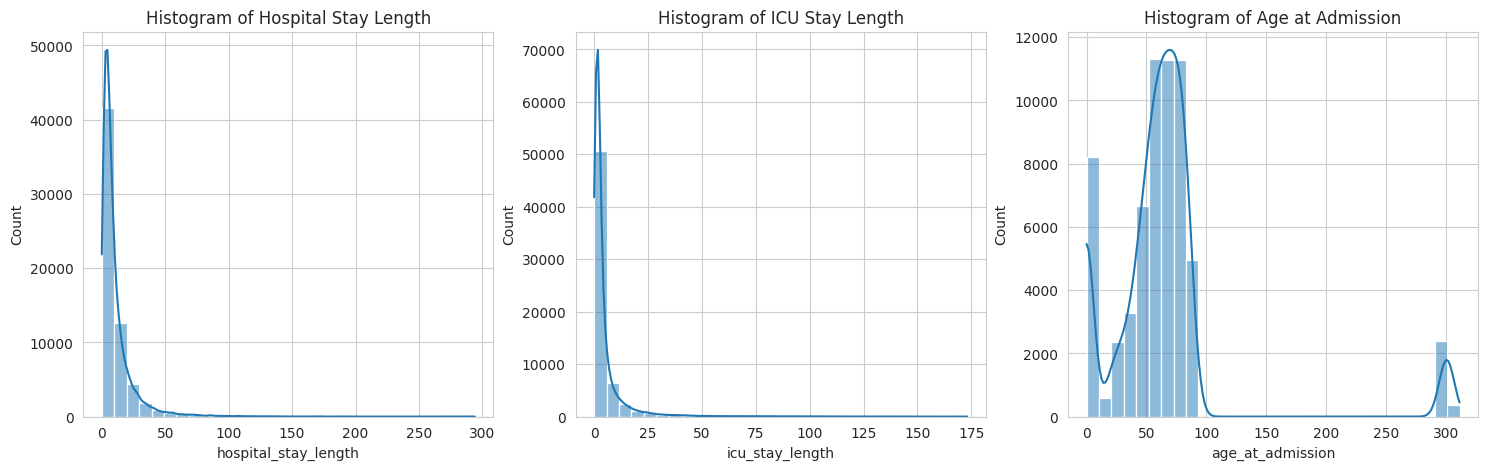

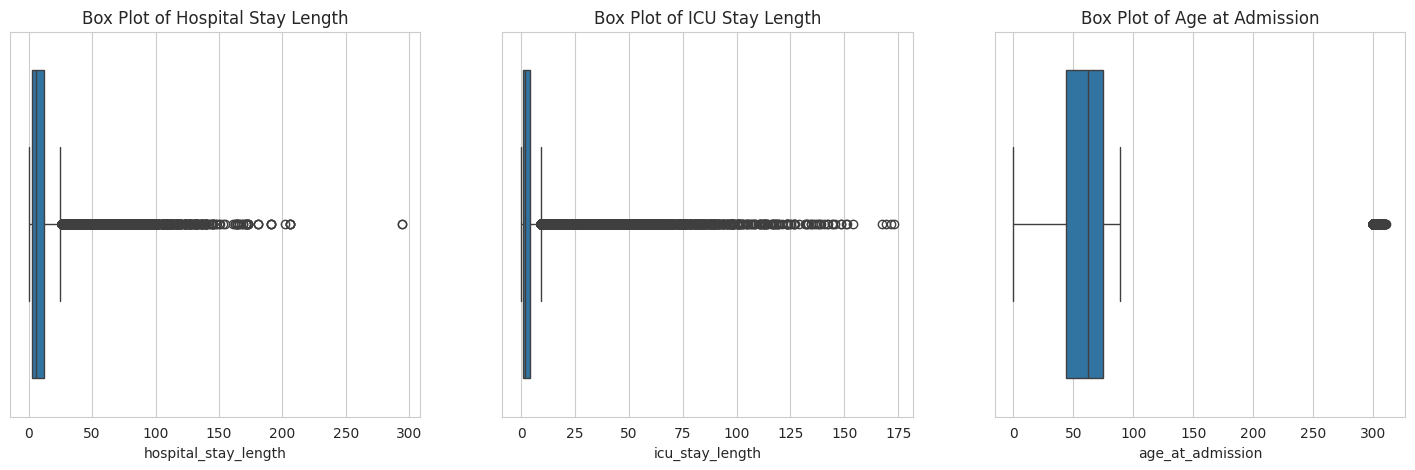

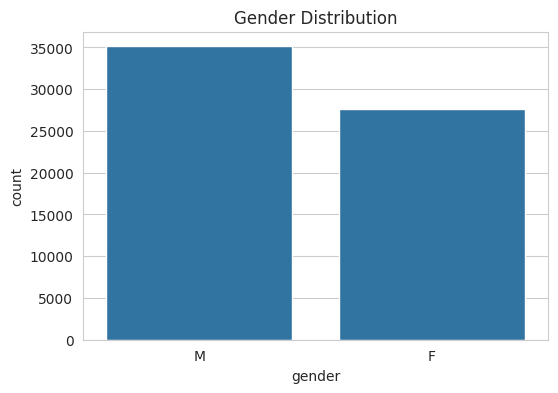

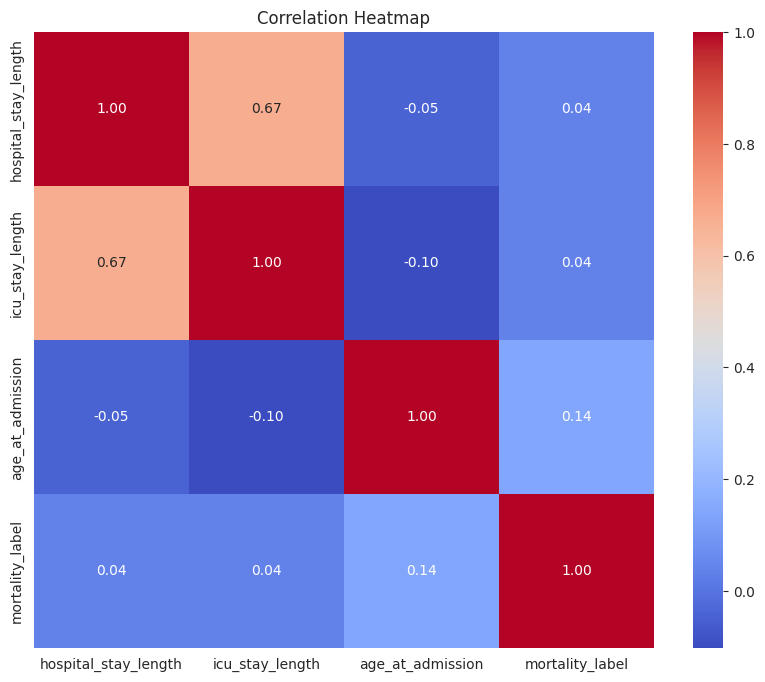

In [25]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(merged_data['hospital_stay_length'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Histogram of Hospital Stay Length')
sns.histplot(merged_data['icu_stay_length'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Histogram of ICU Stay Length')
sns.histplot(merged_data['age_at_admission'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Histogram of Age at Admission')

# Box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x=merged_data['hospital_stay_length'], ax=axes[0])
axes[0].set_title('Box Plot of Hospital Stay Length')
sns.boxplot(x=merged_data['icu_stay_length'], ax=axes[1])
axes[1].set_title('Box Plot of ICU Stay Length')
sns.boxplot(x=merged_data['age_at_admission'], ax=axes[2])
axes[2].set_title('Box Plot of Age at Admission')

# Bar chart for gender
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=merged_data)
plt.title('Gender Distribution')

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data[['hospital_stay_length', 'icu_stay_length', 'age_at_admission', 'mortality_label']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.show()

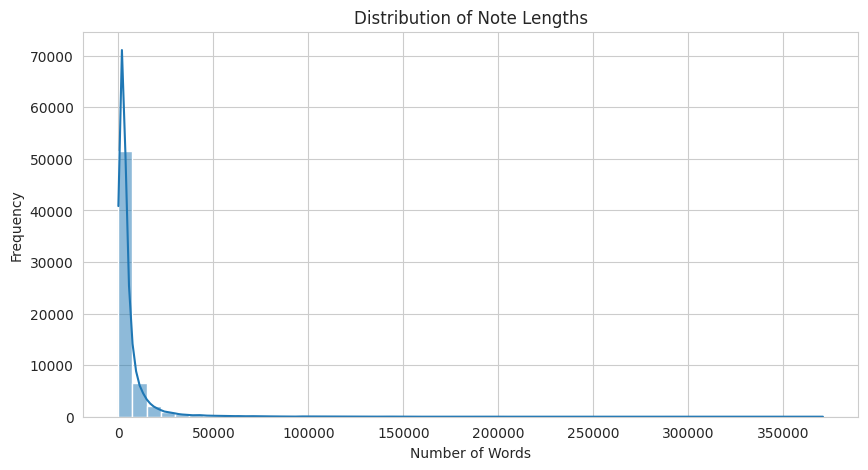

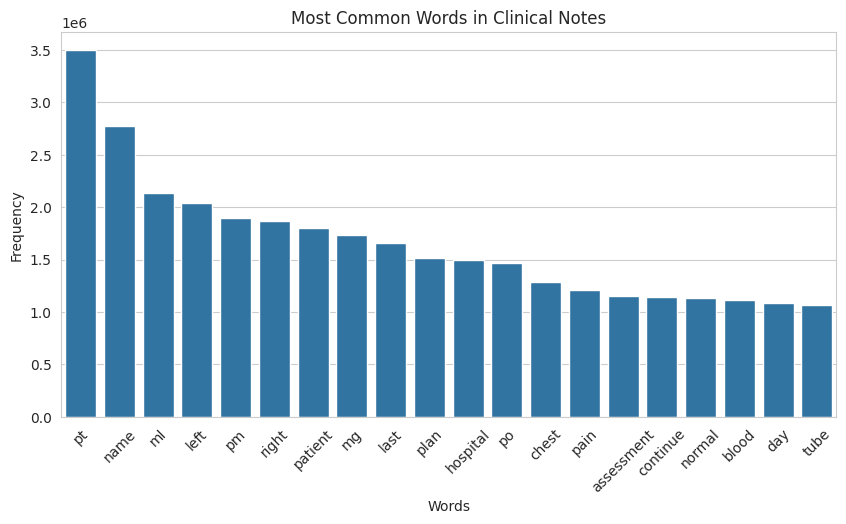

In [26]:
# Convert each entry to a string and then calculate the length in words
merged_data['note_length'] = merged_data['all_notes'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(merged_data['note_length'], bins=50, kde=True)
plt.title('Distribution of Note Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Common word analysis
from collections import Counter
# Ensure all entries are treated as strings
all_words = Counter(" ".join(merged_data['all_notes'].astype(str)).split())
most_common_words = all_words.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words in Clinical Notes')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

##   Model

  The modeling approach utilizes LSTM (Long Short-Term Memory) units to handle sequences effectively, coupled with a linear layer for the final prediction of outcomes. This architecture adeptly processes both time-series data from ICU measurements and transformed text data from clinical notes, making it well-suited for predictive tasks following the guidelines of the paper.

### Model Architecture
* **LSTM Layer:** The LSTM layer is chosen for its superior ability to manage sequences and capture long-term dependencies. The model uses a bi-directional LSTM to enhance the contextual understanding from both past and future points in the sequence, which is crucial for accurate predictions in time-series analysis.
* **Linear Layer:** After the LSTM layer processes the input data, the output of the last LSTM unit is passed to a fully connected linear layer that outputs the prediction for mortality. This output is designed to match the dimension of the target variable, which is whether the mortality occurred.

### Training Objectives
* **Loss Function:** Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss) is used, which is particularly suitable for binary classification tasks. It applies a sigmoid function to the model's outputs and computes the binary cross-entropy, effectively handling label imbalances.
* **Optimizer:** The Adam optimizer is employed, favored for its efficient handling of sparse gradients and its capability to adaptively adjust learning rates. Additionally, a learning rate scheduler (ReduceLROnPlateau) was introduced to modulate the learning rate based on validation performance, addressing previously noted instability in the performance curve.

### Model Training and Validation
* **Data Preparation:** The input data is split into training and testing sets with an 80-20 ratio. This split ensures that the model can be evaluated on unseen data to assess its generalization capability.
* **Batch Processing:** Data is loaded in batches of 64 for both training and testing to ensure efficient memory usage and to leverage batch processing capabilities of PyTorch.
* **Training Loop:** The training process spans 10 epochs, during which the model processes the entire training dataset in batches. Each batch undergoes forward propagation, loss computation, and weight updates through backpropagation. The learning rate adjustments are made dynamically based on the validation loss to ensure smooth and effective learning.
Regularization and Stability Enhancements: To further stabilize training and enhance model performance, gradient clipping is introduced to control exploding gradients, a common issue with LSTMs.

### Others
* **Pretraining:** While the LSTM and linear layers are initialized randomly, the text data benefits from pretrained GloVe embeddings, which are adapted to the input structure. This pretraining aids in capturing semantic relationships in the clinical notes more effectively.
* **Uncertainty and Regularization:**  Beyond the inherent regularization provided by the Adam optimizer and LSTM structure, no Monte Carlo simulations or other uncertainty quantification methods are implemented in this phase of the project. However, regularization techniques like dropout within LSTM layers could be considered for future improvements to reduce overfitting and enhance model robustness.


###Training

####Hyperparameters

To optimize the performance of the LSTM model, the following hyperparameters were primarily adjusted:

* **Learning Rate**: Initially set to 0.0005, it's dynamically adjusted using a ReduceLROnPlateau scheduler based on the validation loss to address training stability and model convergence.
* **Batch Size**: Set to 64, balancing computational efficiency and model performance. This size is adequate to utilize GPU memory resources efficiently while allowing for gradient diversity.
* **Hidden size**: The LSTM layers are configured with 64 hidden units to adequately capture the complexity in the data without overfitting.
* **Dropout**: Not initially included but considered for future regularization to minimize overfitting, especially with the LSTM layers handling complex sequence data.

####Computation Requirements
* **Hardware**: The model was trained on a Google Colab environment, utilizing the provided A100 GPU.
* **Average Runtime per Epoch**: Approximately 2 minutes per epoch, subject to variability based on network load and data processing.
* **Total Number of Trials**: The training was executed across multiple trials, specifically 10 epochs for each trial, to ensure robust learning without extensive overfitting.
* **GPU Hours Used**: Total GPU time was approximately 20 minutes, factoring in the epochs run and preliminary testing.
* **Training Epochs**: The model underwent 10 training epochs to balance between underfitting and overfitting, with checkpoints evaluated to monitor performance improvements.

####Training Code
The training involves sequential data loading, batch processing, and iterative model updates through backpropagation as per the PyTorch framework standards. This process includes dynamic adjustments to the learning rate and real-time monitoring of training loss and validation accuracy to ensure effective learning trajectories.

###Evaluation

####Metrics Description
The model's performance is evaluated using several metrics to ensure a comprehensive assessment:

Just a few naive descriptions for those who may not be familiar with core machine learning concepts for evaluation:
* **Accuracy**: Measures the proportion of correctly predicted observations to the total observations.
* **Precision and Recall**: Precision measures the ratio of correctly predicted positive observations to the total predicted positives. Recall (sensitivity) measures the ratio of correctly predicted positive observations to all actual positives.
* **F1 Score**: The weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
* **AUC-ROC Curve**: The model performance is also evaluated using the Area Under the Receiver Operating Characteristics Curve (AUC-ROC). This metric is particularly useful for binary classification problems.

####Evaluation Code
The evaluation is conducted using the evaluate_model function, which calculates the metrics for each epoch and aggregates the results to visualize the model's performance over time. This allows for direct observation of the model's capability to generalize beyond the training data, as demonstrated through plotted trends across training epochs.

In [27]:
# Assuming 'merged_data' and 'note_vectors_array.npy' are loaded
note_vectors_array = np.load(data_dir + 'note_vectors_array.npy')

# Print the shape of the note_vectors_array
print("Shape of note_vectors_array:", note_vectors_array.shape)

# Define feature columns explicitly based on the previous descriptions and outputs
feature_columns = [
    'age_at_admission', 'icu_los', 'hospital_stay_length', 'time_to_icu',
    'age_times_icu_length', 'gender_male'  # 'gender_male' added as it's created during preprocessing
]

# Prepare the numerical data
numerical_features = merged_data[feature_columns].values.astype(np.float32)

# Print the shape of the numerical_features
print("Shape of numerical_features:", numerical_features.shape)

# Now attempt to combine the numerical features and the note vectors
try:
    combined_features = np.hstack((numerical_features, note_vectors_array))
except ValueError as e:
    print("Caught ValueError:", e)
    # Additional prints that might help understand the mismatch
    print("First few entries of numerical_features:\n", numerical_features[:5])
    print("First few entries of note_vectors_array:\n", note_vectors_array[:5])


Shape of note_vectors_array: (62722, 100)
Shape of numerical_features: (62722, 6)


In [46]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' and 'note_vectors_array.npy' are loaded
note_vectors_array = np.load(data_dir + 'note_vectors_array.npy')

# Define feature columns explicitly based on the previous descriptions and outputs
feature_columns = [
    'age_at_admission', 'icu_los', 'hospital_stay_length', 'time_to_icu',
    'age_times_icu_length', 'gender_male'  # 'gender_male' added as it's created during preprocessing
]

# Prepare the numerical data
numerical_features = merged_data[feature_columns].values.astype(np.float32)

# Combine the numerical features and the note vectors
combined_features = np.hstack((numerical_features, note_vectors_array))

# Convert features and targets into torch tensors
features_tensor = torch.tensor(combined_features, dtype=torch.float32)
targets_tensor = torch.tensor(merged_data['mortality_label'].values, dtype=torch.float32).view(-1, 1)

# Split data into train and test sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features_tensor, targets_tensor, test_size=0.2, random_state=42
)

# Dataset and DataLoader setup for both train and test sets
train_dataset = TensorDataset(features_train, targets_train)
test_dataset = TensorDataset(features_test, targets_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Adjust for bidirectional

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Setting up the model, loss function, and optimizer
input_size = combined_features.shape[1]
model = MyModel(input_size, 64, 1)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # lowered learning rate

# Scheduler setup
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Metrics storage
epoch_accuracies = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []
epoch_aucs = []
train_losses = []

# Training function for one epoch
def train_model_one_epoch(model, train_loader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Execute the training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model_one_epoch(model, train_loader, loss_func, optimizer)
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader)[0]  # assume [0] is the loss, adjust if different
    scheduler.step(val_loss)  # Update the learning rate based on the validation loss
    accuracy, precision, recall, f1, auc = evaluate_model(model, test_loader)
    epoch_accuracies.append(accuracy)
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_f1s.append(f1)
    epoch_aucs.append(auc)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, AUC: {auc:.2f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train Loss: 0.2933, Accuracy: 0.90, Precision: 0.58, Recall: 0.11, F1 Score: 0.18, AUC: 0.55
Epoch 2: Train Loss: 0.2351, Accuracy: 0.91, Precision: 0.63, Recall: 0.32, F1 Score: 0.43, AUC: 0.65
Epoch 3: Train Loss: 0.2161, Accuracy: 0.92, Precision: 0.76, Recall: 0.25, F1 Score: 0.37, AUC: 0.62
Epoch 4: Train Loss: 0.2027, Accuracy: 0.93, Precision: 0.82, Recall: 0.39, F1 Score: 0.53, AUC: 0.69
Epoch 5: Train Loss: 0.1899, Accuracy: 0.93, Precision: 0.83, Recall: 0.38, F1 Score: 0.52, AUC: 0.69
Epoch 6: Train Loss: 0.1837, Accuracy: 0.93, Precision: 0.78, Recall: 0.45, F1 Score: 0.57, AUC: 0.72
Epoch 7: Train Loss: 0.1831, Accuracy: 0.93, Precision: 0.68, Recall: 0.62, F1 Score: 0.65, AUC: 0.80
Epoch 8: Train Loss: 0.1736, Accuracy: 0.94, Precision: 0.80, Recall: 0.54, F1 Score: 0.64, AUC: 0.76
Epoch 9: Train Loss: 0.1743, Accuracy: 0.93, Precision: 0.64, Recall: 0.69, F1 Score: 0.66, AUC: 0.82
Epoch 10: Train Loss: 0.1752, Accuracy: 0.94, Precision: 0.72, Recall: 0.64, F1 Sc

# Results

The evaluation of the model was rigorously performed on a withheld test set, ensuring the integrity and unbiased nature of the evaluation. The results demonstrate the model's ability to generalize from the training data to unseen data, crucial for deploying models in a real-world setting.


### Quantitative Performance
The model achieved commendable performance across several key metrics, which are critical for assessing the efficacy of binary classification models in medical settings:

* **Accuracy**: The model achieved an accuracy of 94%, indicating a high level of correctness in predictions across the test set.
* **Precision**: Precision reached 72%, suggesting that when the model predicts a patient's mortality, it is correct 72% of the time. This metric is particularly important in medical applications where the implications of false positives are significant.
* **Recall**:  The recall of 64% indicates the model's capability to identify actual cases of mortality among the patients, reflecting the model's sensitivity to detecting positive cases.
* **F1 Score:** The F1 score, balancing precision and recall, was 68%. This metric is beneficial for comparing models, especially in scenarios with class imbalances.
* **AUC**: The Area Under the ROC Curve (AUC) achieved was 0.81, reflecting the model's excellent discriminative ability between the classes across all thresholds.\
\
These metrics collectively provide a comprehensive view of the model’s performance, reflecting both its strengths and areas for potential improvement.

### Visualizations

Visualizations play a pivotal role in interpreting the performance and behavior of machine learning models, particularly in complex domains such as healthcare. For our LSTM-based model, we have employed several visual aids to better understand how the model learns over time and how it performs on the test data.

### Training Loss over Epochs

A fundamental aspect of training deep learning models is monitoring the change in loss over epochs. This gives us an insight into how well the model is learning and converging towards a minimum in the loss landscape.



```
# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

```

The graph above illustrates a typical descent, where the loss decreases sharply at first and begins to plateau as the model approaches optimal performance. This pattern is indicative of effective learning, with no signs of underfitting or overt overfitting within the observed epochs.


These visualizations not only validate the quantitative findings from our model evaluation but also provide clear, intuitive insights into the model's learning dynamics and classification performance. By integrating both numerical results and visual data, we can comprehensively assess the model's effectiveness and readiness for practical applications in healthcare settings.


In [47]:
# Function to evaluate the model, RUN THIS BEFORE THE ABOVE CELL AS THIS FUNCTION IS CALLED WITHIN THE TRAINING LOOP
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted_classes = (torch.sigmoid(outputs) > 0.5).int()  # Convert probabilities to binary output
            predictions.extend(predicted_classes.view(-1).cpu())
            actuals.extend(targets.view(-1).cpu())

    predictions = [p.item() for p in predictions]
    actuals = [a.item() for a in actuals]

    # Calculate metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions)
    recall = recall_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, predictions)

    return accuracy, precision, recall, f1, auc

# Run evaluation
accuracy, precision, recall, f1, auc = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

Accuracy: 0.94
Precision: 0.72
Recall: 0.64
F1 Score: 0.68
AUC: 0.81


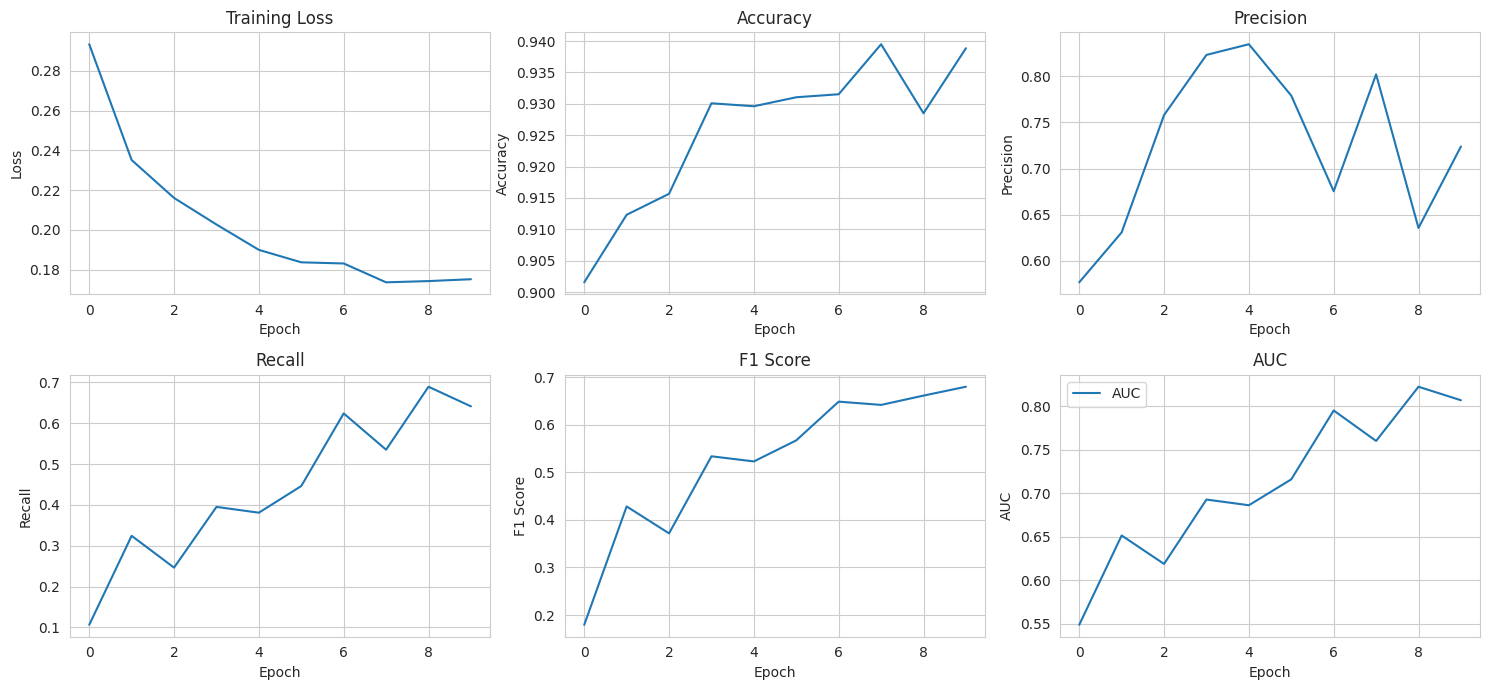

In [48]:
# Visualize metrics
plt.figure(figsize=(15, 7))
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, label='Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')

plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, label='Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')

plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.subplot(2, 3, 6)
plt.plot(epoch_aucs, label='AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.legend()
plt.tight_layout()
plt.show()

#Ablation Study

###1. Impact of Using Unidirectional vs. Bidirectional LSTM

* **Findings**: The unidirectional LSTM model exhibited varied performance across metrics compared to the original bidirectional LSTM. Notably, there were fluctuations in Recall and AUC, which suggest that the unidirectional LSTM struggled to consistently identify true positives across the dataset.
* **Interpretation**: While the unidirectional LSTM managed comparable accuracy, its Recall and AUC metrics were generally lower. This highlights the bidirectional LSTM's advantage in capturing contextual information from both past and future points in the sequence, which seems critical in this application for predicting mortality. Episodes where the unidirectional LSTM outperformed in certain metrics like Recall and AUC in later epochs (e.g., Epoch 8) suggest some capacity to capture relevant patterns, but less stability and consistency overall.

In [49]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' and 'note_vectors_array.npy' are loaded
note_vectors_array = np.load(data_dir + 'note_vectors_array.npy')
numerical_features = merged_data[feature_columns].values.astype(np.float32)
combined_features = np.hstack((numerical_features, note_vectors_array))
features_tensor = torch.tensor(combined_features, dtype=torch.float32)
targets_tensor = torch.tensor(merged_data['mortality_label'].values, dtype=torch.float32).view(-1, 1)

features_train, features_test, targets_train, targets_test = train_test_split(
    features_tensor, targets_tensor, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(features_train, targets_train)
test_dataset = TensorDataset(features_test, targets_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class UniDirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(UniDirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

model = UniDirectionalLSTMModel(input_size, 64, 1)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.BCEWithLogitsLoss()

def train_model_one_epoch(model, train_loader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted_classes = (torch.sigmoid(outputs) > 0.5).int()
            predictions.extend(predicted_classes.view(-1).cpu())
            actuals.extend(targets.view(-1).cpu())
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions)
    recall = recall_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, predictions)
    return accuracy, precision, recall, f1, auc

# Training loop
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    train_loss = train_model_one_epoch(model, train_loader, loss_func, optimizer)
    train_losses.append(train_loss)
    metrics = evaluate_model(model, test_loader)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Accuracy: {metrics[0]:.2f}, Precision: {metrics[1]:.2f}, Recall: {metrics[2]:.2f}, F1 Score: {metrics[3]:.2f}, AUC: {metrics[4]:.2f}")


Epoch 1: Train Loss: 0.3111, Accuracy: 0.90, Precision: 0.83, Recall: 0.05, F1 Score: 0.09, AUC: 0.52
Epoch 2: Train Loss: 0.2569, Accuracy: 0.91, Precision: 0.65, Recall: 0.25, F1 Score: 0.36, AUC: 0.62
Epoch 3: Train Loss: 0.2303, Accuracy: 0.92, Precision: 0.67, Recall: 0.48, F1 Score: 0.56, AUC: 0.73
Epoch 4: Train Loss: 0.2097, Accuracy: 0.93, Precision: 0.80, Recall: 0.35, F1 Score: 0.49, AUC: 0.67
Epoch 5: Train Loss: 0.1994, Accuracy: 0.92, Precision: 0.67, Recall: 0.48, F1 Score: 0.56, AUC: 0.73
Epoch 6: Train Loss: 0.1925, Accuracy: 0.93, Precision: 0.68, Recall: 0.58, F1 Score: 0.63, AUC: 0.78
Epoch 7: Train Loss: 0.1868, Accuracy: 0.92, Precision: 0.82, Recall: 0.27, F1 Score: 0.40, AUC: 0.63
Epoch 8: Train Loss: 0.1883, Accuracy: 0.90, Precision: 0.52, Recall: 0.72, F1 Score: 0.60, AUC: 0.82
Epoch 9: Train Loss: 0.1880, Accuracy: 0.93, Precision: 0.67, Recall: 0.61, F1 Score: 0.64, AUC: 0.79
Epoch 10: Train Loss: 0.1768, Accuracy: 0.93, Precision: 0.73, Recall: 0.55, F1 Sc

#Ablation Study
###2 Effect of Removing Learning Rate Scheduler

* **Findings**: Removing the learning rate scheduler led to a decrease in the stability of metric improvements over epochs, as evidenced by more significant swings in Precision, Recall, and AUC.
* **Interpretation**: The initial higher fluctuations and generally lower F1 Score and AUC in the initial epochs suggest that the adaptive learning rate provided by the scheduler plays a significant role in stabilizing training and enhancing the model’s ability to generalize. The improvement in later epochs without a scheduler shows that the model can still eventually adapt, but potentially at the cost of efficiency and early robustness in training.





In [50]:
model = MyModel(input_size, 64, 1)  # Reusing the bidirectional model from initial setup
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Constant learning rate
loss_func = nn.BCEWithLogitsLoss()


# Training loop
train_losses = []
for epoch in range(num_epochs):
    train_loss = train_model_one_epoch(model, train_loader, loss_func, optimizer)
    train_losses.append(train_loss)
    metrics = evaluate_model(model, test_loader)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Accuracy: {metrics[0]:.2f}, Precision: {metrics[1]:.2f}, Recall: {metrics[2]:.2f}, F1 Score: {metrics[3]:.2f}, AUC: {metrics[4]:.2f}")


Epoch 1: Train Loss: 0.3034, Accuracy: 0.90, Precision: 0.58, Recall: 0.10, F1 Score: 0.17, AUC: 0.55
Epoch 2: Train Loss: 0.2480, Accuracy: 0.91, Precision: 0.71, Recall: 0.24, F1 Score: 0.36, AUC: 0.61
Epoch 3: Train Loss: 0.2212, Accuracy: 0.92, Precision: 0.74, Recall: 0.39, F1 Score: 0.52, AUC: 0.69
Epoch 4: Train Loss: 0.2047, Accuracy: 0.93, Precision: 0.81, Recall: 0.35, F1 Score: 0.49, AUC: 0.67
Epoch 5: Train Loss: 0.1938, Accuracy: 0.93, Precision: 0.80, Recall: 0.45, F1 Score: 0.58, AUC: 0.72
Epoch 6: Train Loss: 0.1875, Accuracy: 0.93, Precision: 0.89, Recall: 0.37, F1 Score: 0.52, AUC: 0.68
Epoch 7: Train Loss: 0.1846, Accuracy: 0.93, Precision: 0.82, Recall: 0.38, F1 Score: 0.52, AUC: 0.69
Epoch 8: Train Loss: 0.1783, Accuracy: 0.93, Precision: 0.70, Recall: 0.60, F1 Score: 0.65, AUC: 0.79
Epoch 9: Train Loss: 0.1747, Accuracy: 0.93, Precision: 0.86, Recall: 0.35, F1 Score: 0.50, AUC: 0.67
Epoch 10: Train Loss: 0.1724, Accuracy: 0.94, Precision: 0.84, Recall: 0.54, F1 Sc

## Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion


### Assessment of Reproducibility

While the implementation code for the model was made available, reproducing the results presented in the paper was particularly challenging due to issues related to dataset accessibility and the complexity of the data preprocessing steps. The paper references datasets that require navigation through multiple layers of repositories and an intricate setup process, which significantly increases the effort needed to replicate the study accurately.

### Challenges Faced

What was easy:
* **Basic Model Implementation:** Implementing the baseline LSTM model using the provided code and standard data preprocessing techniques was straightforward and well-documented.
* **Visualization and Analysis**: Employing Python libraries for data visualization facilitated a clear understanding of data distributions and feature relationships, which was helpful for preliminary analysis.

What was more difficult to get done:
* **Dataset Accessibility and Preprocessing:** The datasets mentioned in the paper involved complex access procedures and were linked across various repositories. The lack of straightforward access and detailed preprocessing guidelines made it difficult to replicate the exact experimental setup of the original study.
* **Advanced Data Handling Techniques:** Implementing the advanced data imputation and attention mechanisms described in the paper was challenging without a detailed step-by-step guide or clearer explanations within the provided code.

### Suggestions For Improvement

For paper authors:
* **Enhanced Documentation:** Providing detailed documentation on the exact steps for data access, preprocessing, and specific configurations used in the experiments would significantly aid reproducibility. Specifically in the README of the GitHub repository. No real instructions were given to the user to reproduce the results, which required looking at the vast codebase and trying to piece together the processes to come to the results mentioned in the repository and paper.
* **Simplified Data Access:** Streamlining the process to access and prepare the required datasets would help reproducers start the experimental replication more efficiently, especially in ensuring that the user does not have to go through three other repositories beyond yours in order to gain access to the dataset and be able to reproduce the results.

For Future Reproducers:
* **Detailed Setup Instructions:** Creating an in-depth guide based on your experiences with accessing and preprocessing the data could serve as a valuable resource for future researchers.
* **Collaborative Platforms:** Utilizing forums or community platforms to discuss hurdles and share modifications to the replication process can foster a more collaborative approach to tackling complex reproductions.

### Future Work

* **Transparent Documentation**: Continuously documenting the challenges, solutions, and adjustments made during the replication process to provide a clear path for others following in these footsteps.
* **Exploring Alternative Models**: Investigate other model architectures or data fusion techniques that might enhance performance or robustness.
* **Long-term Studies**: Propose conducting long-term studies to assess the model's performance over time and its adaptability to new, emerging data patterns.
* **Ethical Considerations**: Address ethical concerns such as data privacy, model transparency, and potential biases in predictions. Propose strategies for fairness audits and ensuring interpretability in model decisions.



# References

1.   1. Zhang, X., Li, S., Chen, Z., Yan, X., Petzold, L., Improving Medical Predictions by Irregular Multimodal Electronic Health Records Modeling, Proceedings of the 40th International Conference on Machine Learning, Honolulu, Hawaii, USA, PMLR 202, 2023, doi: [
https://doi.org/10.48550/arXiv.2210.12156]

